In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import time

df = pd.read_csv('16P.csv',encoding="macroman")
df_data = df.head(59999)
print("c")
index_ = df_data.Personality
df_data.index = index_
df_new = df_data.drop(columns=['Response Id'])

df_new.loc[df_new['Personality'] == 'ESTJ', 'Personality'] = 0
df_new.loc[df_new['Personality'] == 'ENTJ', 'Personality'] = 1
df_new.loc[df_new['Personality'] == 'ESFJ', 'Personality'] = 2
df_new.loc[df_new['Personality'] == 'ENFJ', 'Personality'] = 3
df_new.loc[df_new['Personality'] == 'ISTJ', 'Personality'] = 4
df_new.loc[df_new['Personality'] == 'ISFJ', 'Personality'] = 5
df_new.loc[df_new['Personality'] == 'INTJ', 'Personality'] = 6
df_new.loc[df_new['Personality'] == 'INFJ', 'Personality'] = 7
df_new.loc[df_new['Personality'] == 'ESTP', 'Personality'] = 8
df_new.loc[df_new['Personality'] == 'ESFP', 'Personality'] = 9
df_new.loc[df_new['Personality'] == 'ENTP', 'Personality'] = 10
df_new.loc[df_new['Personality'] == 'ENFP', 'Personality'] = 11
df_new.loc[df_new['Personality'] == 'ISTP', 'Personality'] = 12
df_new.loc[df_new['Personality'] == 'ISFP', 'Personality'] = 13
df_new.loc[df_new['Personality'] == 'INTP', 'Personality'] = 14
df_new.loc[df_new['Personality'] == 'INFP', 'Personality'] = 15

c


In [2]:
data = np.array(df_new)
new = np.array(data[:,-1])
new = np.reshape(new,(len(data),1))
normalizedData = (data[:,:-1]-np.min(data[:,:-1]))/(np.max(data[:,:-1])-np.min(data[:,:-1]))
normalizedData = np.append(normalizedData,new,axis=1)
data = np.array(data,dtype='int64')
normalizedData = np.array(normalizedData,dtype='int64')
fold1 = data[:int(len(data)//5)]
fold2 = data[int(len(data)//5):int(len(data)//5)*2]
fold3 = data[int(len(data)//5)*2:int(len(data)//5)*3]
fold4 = data[int(len(data)//5)*3:int(len(data)//5)*4]
fold5 = data[int(len(data)//5)*4:]
train1 = np.vstack((fold2,fold3,fold4,fold5))
train2 = np.vstack((fold1,fold3,fold4,fold5))
train3 = np.vstack((fold1,fold2,fold4,fold5))
train4 = np.vstack((fold1,fold2,fold3,fold5))
train5 = np.vstack((fold1,fold2,fold3,fold4))
nfold1 = normalizedData[:int(len(data)//5)]
nfold2 = normalizedData[int(len(data)//5):int(len(data)//5)*2]
nfold3 = normalizedData[int(len(data)//5)*2:int(len(data)//5)*3]
nfold4 = normalizedData[int(len(data)//5)*3:int(len(data)//5)*4]
nfold5 = normalizedData[int(len(data)//5)*4:]
ntrain1 = np.vstack((nfold2,nfold3,nfold4,nfold5))
ntrain2 = np.vstack((nfold1,nfold3,nfold4,nfold5))
ntrain3 = np.vstack((nfold1,nfold2,nfold4,nfold5))
ntrain4 = np.vstack((nfold1,nfold2,nfold3,nfold5))
ntrain5 = np.vstack((nfold1,nfold2,nfold3,nfold4))
folders = [(fold1,train1),(fold2,train2),(fold3,train3),(fold4,train4),(fold5,train5)]
nfolders = [(nfold1,ntrain1),(nfold2,ntrain2),(nfold3,ntrain3),(nfold4,ntrain4),(nfold5,ntrain5)]

In [3]:
def euclidian_distances(fold, train):
    x2 = np.sum(fold**2, axis=1)
    y2 = np.sum(train**2, axis=1)
    xy = np.matmul(fold, train.T)
    x2 = x2.reshape(-1,1)
    distance = (x2 -2*xy + y2)**0.5
    return distance

In [4]:
def sort(fold,train,k):
    global time10
    dist = euclidian_distances(fold,train)
    a = np.argsort(dist)
    b = train[:,60][a]
    u, indices = np.unique(b[:,:k], return_inverse=True)
    c = u[np.argmax(np.apply_along_axis(np.bincount, 1, indices.reshape(b[:,:k].shape),
                                    None, np.max(indices) + 1), axis=1)]
    
    arr = np.stack((fold[:,60],c),axis = 1)
    q = np.where(arr[:,0] != arr[:,1])
    print(f"Prediction: {arr[q][0][1]} True Value: {arr[q][0][0]}, List of Predictions: {b[q][0][:k]}")

    return arr


daccur = []
dprec = []
drecall = []
naccur = []
nprec = []
nrecall = []

In [5]:
time3 = time.time()
def kNN_algorithm(folder,accur,prec,recall,k):
    global conf_modal1
    Overall_recall,Overall_precision,Overall_accuracy = 0,0,0
    for m,n in folder:
        j = sort(m,n,k)
        j = j.tolist()
        overall_recall,overall_precision,overall_accuracy = 0,0,0
        classes = pd.DataFrame(j, columns=['Actual_Class','Pred_Class'])
        conf_modal1 = pd.crosstab(classes.Pred_Class,classes.Actual_Class)
        for i in range(conf_modal1.shape[0]):
            TP = conf_modal1.iloc[i,i]
            FP = conf_modal1.iloc[i,:].sum() - TP
            FN = conf_modal1.iloc[:,i].sum()- TP
            TN = conf_modal1.sum().sum()-TP-FP-FN
            Accuracy1 = (TP+TN)/conf_modal1.sum().sum()
            Precision1 = TP/(TP+FP)
            Recall1 = TP/(TP+FN)
            overall_recall += Recall1
            overall_precision += Precision1
            overall_accuracy += Accuracy1
        Overall_accuracy += overall_accuracy
        Overall_precision += overall_precision
        Overall_recall += overall_recall
    accur.append(Overall_accuracy/80)
    prec.append(Overall_precision/80)
    recall.append(Overall_recall/80)

# ERROR ANALYSIS FOR CLASSIFICATION

  Our kNN algorithm's performance going to up when the value of k increases. We can see results on the graphs and dataframes. Also if our data is increased,like 1 million not 60k, our accuracys,precisions and recalls going up. Every change on the folders,datas or value of k effects our kNN algorithm.

In [6]:
time1 = time.time()
for k in range(1,10,2):
    print(f"Value of k: {k}")
    kNN_algorithm(folders,daccur,dprec,drecall,k)
time2= time.time()
print(time2-time1)

Value of k: 1
Prediction: 7 True Value: 4, List of Predictions: [7]
Prediction: 6 True Value: 7, List of Predictions: [6]
Prediction: 9 True Value: 7, List of Predictions: [9]
Prediction: 0 True Value: 2, List of Predictions: [0]
Prediction: 13 True Value: 14, List of Predictions: [13]
Value of k: 3
Prediction: 7 True Value: 4, List of Predictions: [7 7 7]
Prediction: 5 True Value: 9, List of Predictions: [5 5 5]
Prediction: 9 True Value: 7, List of Predictions: [9 9 7]
Prediction: 0 True Value: 2, List of Predictions: [0 0 2]
Prediction: 3 True Value: 0, List of Predictions: [3 3 3]
Value of k: 5
Prediction: 7 True Value: 4, List of Predictions: [7 7 7 7 7]
Prediction: 5 True Value: 9, List of Predictions: [ 5  5  5 12  5]
Prediction: 9 True Value: 7, List of Predictions: [9 9 7 5 3]
Prediction: 0 True Value: 2, List of Predictions: [0 0 2 4 3]
Prediction: 3 True Value: 0, List of Predictions: [3 3 3 3 3]
Value of k: 7
Prediction: 7 True Value: 4, List of Predictions: [7 7 7 7 7 7 7]


I gave 5 examples for each values of k. You can see the errors. We can see some of prediction lists have true value but the most frequent value is not true value. If our data more bigger then given data, our accuracy will be increase.

In [7]:
time3= time.time()
for k in range(1,10,2):
    print(f"Value of k: {k}")
    kNN_algorithm(nfolders,naccur,nprec,nrecall,k)
time4= time.time()
print(time4-time3)

Value of k: 1
Prediction: 10 True Value: 9, List of Predictions: [10]
Prediction: 11 True Value: 10, List of Predictions: [11]
Prediction: 3 True Value: 2, List of Predictions: [3]
Prediction: 3 True Value: 2, List of Predictions: [3]
Prediction: 5 True Value: 4, List of Predictions: [5]
Value of k: 3
Prediction: 13 True Value: 12, List of Predictions: [12 13 13]
Prediction: 3 True Value: 4, List of Predictions: [3 3 4]
Prediction: 11 True Value: 10, List of Predictions: [10 11 11]
Prediction: 13 True Value: 14, List of Predictions: [14 15 13]
Prediction: 2 True Value: 3, List of Predictions: [2 2 4]
Value of k: 5
Prediction: 8 True Value: 9, List of Predictions: [8 8 8 8 8]
Prediction: 8 True Value: 7, List of Predictions: [8 7 7 8 8]
Prediction: 10 True Value: 9, List of Predictions: [10 10 10 10 10]
Prediction: 1 True Value: 2, List of Predictions: [1 1 1 2 2]
Prediction: 2 True Value: 3, List of Predictions: [2 2 4 3 3]
Value of k: 7
Prediction: 8 True Value: 9, List of Predictions

I gave 5 examples for each values of k. You can see the errors. We can see some of prediction lists have true value but the most frequent value is not true value. If our data more bigger then given data, our accuracy will be increase.

In [8]:
timen = time2-time1
timed = time4-time3
times = [timen,timed]
timeframe = pd.DataFrame(times,index=['Normal Data','Normalized Data'],columns=['Time(second)'])
timeframe

,Time(second)
Normal Data,2841.487063
Normalized Data,3886.574271


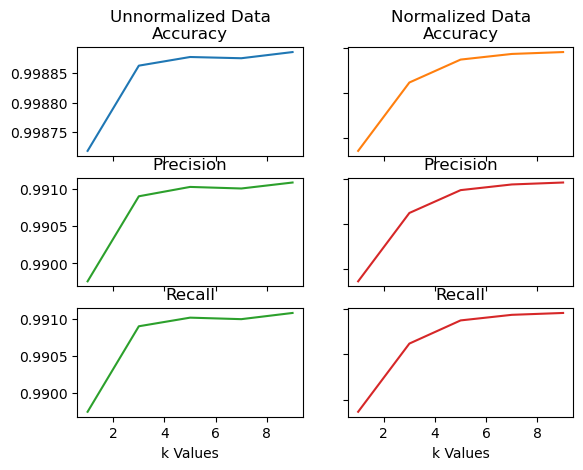

In [9]:
fig, axs = plot.subplots(3, 2)
x = range(1,10,2)
y = [daccur,dprec,drecall,naccur,nprec,nrecall]
axs[0, 0].plot(x, y[0])
axs[0, 0].set_title('Unnormalized Data\nAccuracy')
axs[0, 1].plot(x, y[3], 'tab:orange')
axs[0, 1].set_title('Normalized Data\nAccuracy')
axs[1, 0].plot(x, y[1], 'tab:green')
axs[1, 0].set_title('Precision')
axs[1, 1].plot(x, y[4], 'tab:red')
axs[1, 1].set_title('Precision')
axs[2, 0].plot(x, y[2], 'tab:green')
axs[2, 0].set_title('Recall')
axs[2, 1].plot(x, y[5], 'tab:red')
axs[2, 1].set_title('Recall')
for ax in axs.flat:
    ax.set(xlabel='k Values')

for ax in axs.flat:
    ax.label_outer()

In [10]:
final_frame = pd.DataFrame(zip(daccur,dprec,drecall),index=[1,3,5,7,9],columns=["Accuracy","Precision","Recall"])
final_frame = final_frame.style.set_caption('NORMAL DATA')
final_frame

,Accuracy,Precision,Recall
1,0.998719,0.989761,0.989751
3,0.998862,0.990899,0.990901
5,0.998877,0.991024,0.991016
7,0.998875,0.991003,0.990996
9,0.998885,0.991083,0.991079


In [11]:
final_frame2 = pd.DataFrame(zip(naccur,nprec,nrecall),index=[1,3,5,7,9],columns=["Accuracy","Precision","Recall"])
final_frame2 = final_frame2.style.set_caption('NORMALİZED DATA')
final_frame2

,Accuracy,Precision,Recall
1,0.999431,0.995439,0.995460
3,0.999810,0.998480,0.998479
5,0.999937,0.999495,0.999504
7,0.999969,0.999748,0.999751
9,0.999979,0.999834,0.999834
